In [1]:

import pandas as pd

import sys

import re

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)

import numpy as np

import scipy

import sklearn

import seaborn as sns

import flask

In [2]:
df = pd.read_csv(r"C:\Users\enriq\Your_env_name_Notebooks\Github house_price\Data\houses_Madrid.csv")

# 1. Data Cleaning

In [3]:
pd.set_option("display.max_rows", 90)

In [4]:
pd.set_option("display.max_columns", 70)

In [5]:
df.shape

(21742, 58)

In [6]:
# Lets see what percentage of the rows contain nans for each column. We will discard those columns that have > 50 perc of nans
nan_perc = df.apply(lambda x: (x.isna().sum()/21742)*100)

In [7]:
list_columns_high_nan =[df.columns[i] for i in range(len(nan_perc)) if nan_perc[i] > 30]

In [8]:
df = df.drop(list_columns_high_nan, axis=1)

In [9]:
df = df.drop(["id", "raw_address", "Unnamed: 0"], axis=1)

In [10]:
df.apply(lambda x: (x.isna().sum()/21742)*100)

title                       0.000000
subtitle                    0.000000
sq_mt_built                 0.579524
n_rooms                     0.000000
n_bathrooms                 0.073590
is_exact_address_hidden     0.000000
street_name                27.159415
floor                      11.990617
is_floor_under              5.381290
neighborhood_id             0.000000
operation                   0.000000
rent_price                  0.000000
is_rent_price_known         0.000000
buy_price                   0.000000
buy_price_by_area           0.000000
is_buy_price_known          0.000000
house_type_id               1.798363
is_renewal_needed           0.000000
is_new_development          4.562598
has_lift                   10.974151
is_exterior                13.995953
energy_certificate          0.000000
has_parking                 0.000000
dtype: float64

In [11]:
# Lets remove the "housetype:" part from house_type_id column
spplited_house_type = df["house_type_id"].str.split(":", expand=True)
df["house_type_id"] = spplited_house_type[1]

In [12]:
# Lets parse the euro/m2 from neighborhood_id
pattern = re.compile(r"(\d{4}\.\d+\d?)")
float((pattern.findall(df["neighborhood_id"][0]))[0])

1308.89

In [13]:
lista1=[]
for i in df["neighborhood_id"]:
    x=pattern.findall(i)
    if len(x) == 1:
        lista1.append(float(x[0]))
    else:
        lista1.append(np.nan)    

In [14]:
df["price_m2"] = pd.Series(lista1)

In [15]:
filt = (df["n_rooms"] >= 10)

In [16]:
suspicious = df.loc[filt,["n_rooms","sq_mt_built"]]

In [17]:
suspicious.dropna(inplace=True)

In [18]:
suspicious["room_per_m"] = suspicious["sq_mt_built"]/suspicious["n_rooms"]

In [19]:
suspicious.sort_values(by="room_per_m")

,n_rooms,sq_mt_built,room_per_m
18457,14,207.0,14.785714
18725,10,207.0,20.700000
20619,12,260.0,21.666667
5157,11,250.0,22.727273
17918,10,235.0,23.500000
18941,10,247.0,24.700000
18689,10,247.0,24.700000
17938,10,247.0,24.700000
12875,10,247.0,24.700000
16460,15,390.0,26.000000


In [20]:
def only_pos(num):
    if num < 0:
        return -num
    else:
        return num

In [21]:
def too_high(num):
    if num > 500000:
        return np.nan
    else:
        return num

In [22]:
# The rent_price data is not reliabable

df["rent_price"] = df["rent_price"].apply(only_pos)
df["rent_price"] = df["rent_price"].apply(too_high)

In [23]:
# Lets see how many locations we have in our data = 146 is a number we can handle. 
# Otherwise we could have grouped together part of them in "others"

subtitle_series = df.groupby("subtitle")["subtitle"].count()

In [24]:
lista3=[]
for i in range(len(df["price_m2"])):
    try:
        if df["price_m2"].loc[i] < 7500:
            lista3.append(df["price_m2"].loc[i])
        else:
            lista3.append(df["buy_price_by_area"].loc[i])
    except ValueError:
        lista3.append(np.nan)

In [25]:
df["price_m2"] = pd.Series(lista3)

In [26]:
df = df.drop(["neighborhood_id","title", "rent_price", "operation"], axis=1)

In [27]:
df["total_rooms"] = df["n_rooms"] + df["n_bathrooms"]

In [28]:
df["m2_per_room"] = df["sq_mt_built"]/df["total_rooms"]

In [29]:
filt6 = df["m2_per_room"] < 5 # clear outlier at index  105
df.loc[filt6]
df.drop(105, inplace=True)

In [30]:
filt7 = df["m2_per_room"] > 175 # clear outlier at index  2584, 11039
df.loc[filt7]
df.drop([2584,6350,8541, 11039, 13361, 13794, 18457], inplace=True)

In [31]:
filt8 = df["total_rooms"] > 15 # clear outlier at index  2584, 11039
df.loc[filt8]
df = df.drop(df[filt8].index)

In [32]:
filt9 = df["buy_price"] > 4000000 
df = df.drop(df[filt9].index)

In [33]:
filt10 = df["sq_mt_built"] > 600 # clear outlier at index  2584, 11039
df.loc[filt10]
df = df.drop(df[filt10].index)

In [34]:
filt11 = df["price_m2"] > 10000 # clear outlier at index  2584, 11039
df.loc[filt10]
df = df.drop(df[filt11].index)

In [35]:
# Formatting house_type_id, energy_certificate and floor column (from spanish to english)
df["house_type_id"]= df["house_type_id"].str.strip()

In [36]:
df["house_type_id"] = df["house_type_id"].str.replace("Pisos", "Flat").replace("Áticos", "Attic").replace("Casa o chalet", "House").replace("Dúplex", "Duplex")

In [37]:
df["energy_certificate"] = df["energy_certificate"].str.replace("en trámite", "in process").replace("no indicado", "not indicated").replace("inmueble exento", "exempt property")

In [38]:
df["floor"] = df["floor"].str.replace("Bajo", "0").replace("Entreplanta", "1").replace("Entreplanta interior", "1").replace("Entreplanta exterior", "1").\
replace("Semi-sótano", "-1").replace("Semi-sótano exterior", "-1").replace("Semi-sótano interior", "-1").\
replace("Sótano", "-1").replace("Sótano exterior", "-1").replace("Sótano interior", "-1")

In [39]:
df["subtitle"] = df["subtitle"].str.replace(", Madrid", "")

In [40]:
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("subtitle"):
        m = np.mean(subdf["price_m2"])
        st = np.std(subdf["price_m2"])
        reduced_df = subdf[(subdf["price_m2"]>(m-st)) & (subdf["price_m2"]>=(m+st))]
        df_out= pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [41]:
df_outliers = remove_outliers(df)

In [42]:
df = df_outliers

In [43]:
df["street_name"] = df["street_name"].fillna("missing")
df["floor"] = df["floor"].fillna("missing")
df["is_floor_under"] = df["is_floor_under"].fillna("missing")
df["house_type_id"] = df["house_type_id"].fillna("missing")
df["is_new_development"] = df["is_new_development"].fillna("missing")
df["has_lift"] = df["has_lift"].fillna("missing")
df["is_exterior"] = df["is_exterior"].fillna("missing")

In [44]:
df.dropna(how="any", inplace=True)

In [45]:
df.isna().sum()

subtitle                   0
sq_mt_built                0
n_rooms                    0
n_bathrooms                0
is_exact_address_hidden    0
street_name                0
floor                      0
is_floor_under             0
is_rent_price_known        0
buy_price                  0
buy_price_by_area          0
is_buy_price_known         0
house_type_id              0
is_renewal_needed          0
is_new_development         0
has_lift                   0
is_exterior                0
energy_certificate         0
has_parking                0
price_m2                   0
total_rooms                0
m2_per_room                0
dtype: int64

In [46]:
df.to_csv("data/clean_houses_Madrid.csv", index=False)

In [47]:
df2 = pd.read_csv("data/clean_houses_Madrid.csv")

# 3. EDA (Exploratory Data Analysis)¶

In [48]:
df2.describe()

,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,price_m2,total_rooms,m2_per_room
count,6036.000000,6036.000000,6036.000000,6.036000e+03,6036.000000,6036.000000,6036.000000,6036.000000
mean,121.693009,2.744698,1.829689,5.571907e+05,3982.808482,3773.941549,4.574387,26.017548
std,85.716479,1.224006,1.001649,6.482985e+05,2064.311763,1692.796532,2.009736,10.117793
min,13.000000,0.000000,1.000000,5.400000e+04,795.000000,1574.360000,1.000000,7.500000
25%,70.000000,2.000000,1.000000,1.800000e+05,2397.000000,2443.620000,3.000000,19.750000
50%,94.000000,3.000000,2.000000,2.916000e+05,3433.000000,3163.800000,4.000000,23.333333
75%,136.250000,3.000000,2.000000,6.112500e+05,5126.000000,5390.990000,5.000000,29.200000
max,600.000000,10.000000,7.000000,4.000000e+06,15190.000000,10000.000000,15.000000,135.000000


In [49]:
# Lets create 3 sub dfs with the different data types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
boolean = ['bool']
categorical = ['object']
df_num = df2.select_dtypes(include=numerics)
df_bool = df2.select_dtypes(include=boolean)
df_cat = df2.select_dtypes(include=categorical)

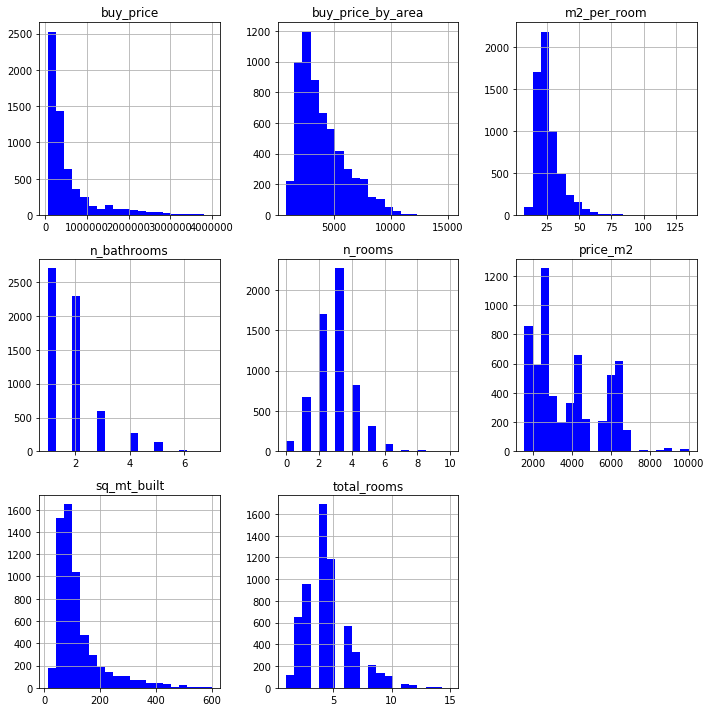

In [50]:
# We could consider normalizing our data
df_num.hist(color="b", bins=20)
plt.tight_layout()
plt.savefig("hist_removed_outliers.png", dpi=400)
plt.show()

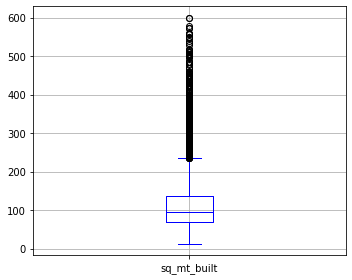

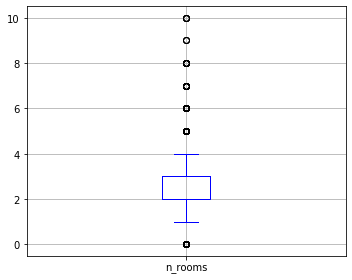

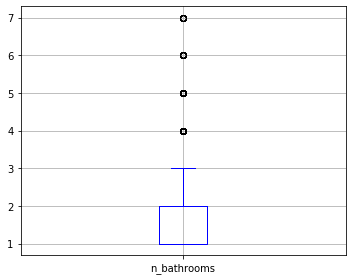

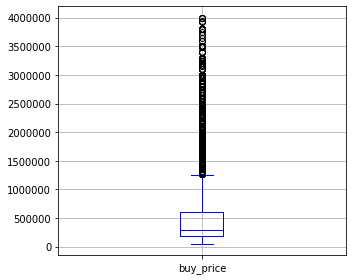

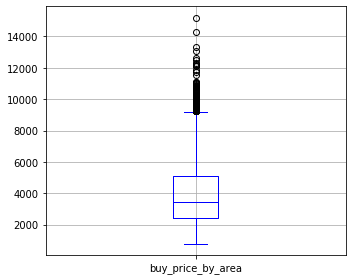

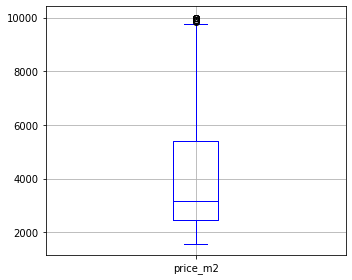

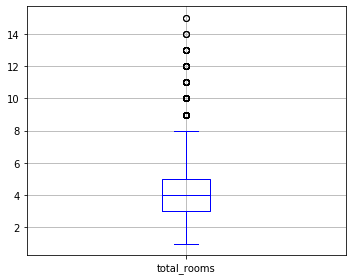

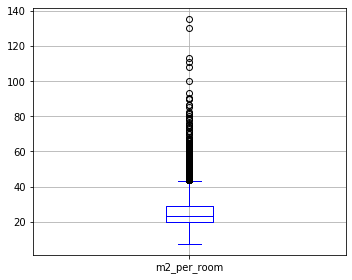

In [51]:
# To spot outliers boxplots can be particularly helpful
for i in df_num.columns:
    fig, ax = plt.subplots(1, figsize=(5, 4))
    df_num[[i]].boxplot(color="b")
    plt.tight_layout()
    plt.show()

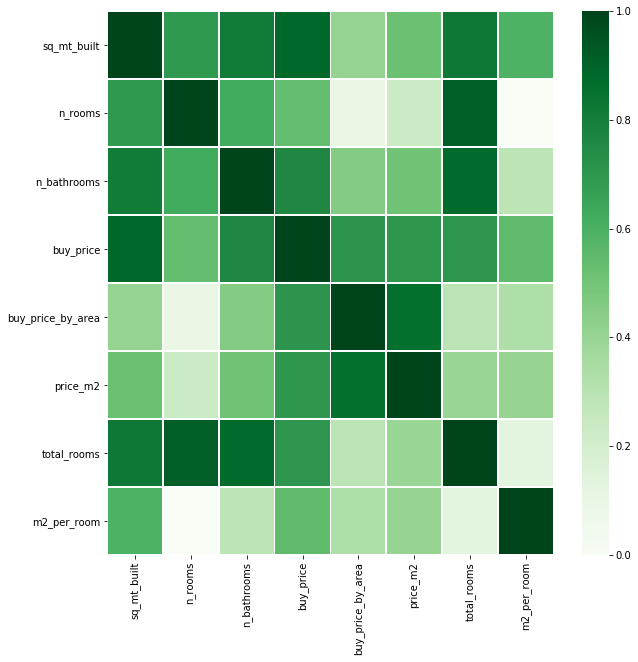

In [52]:
ax = sns.heatmap(df_num.corr(), cmap="Greens",linewidths=.5, vmin=0, vmax=1)
plt.savefig("removed_outliers_corr.png", dpi=400)

In [53]:
df_num.corr()

,sq_mt_built,n_rooms,n_bathrooms,buy_price,buy_price_by_area,price_m2,total_rooms,m2_per_room
sq_mt_built,1.000000,0.693266,0.813887,0.886559,0.409883,0.520869,0.827865,0.593248
n_rooms,0.693266,1.000000,0.627046,0.537615,0.109217,0.231925,0.921557,-0.019504
n_bathrooms,0.813887,0.627046,1.000000,0.764216,0.453646,0.511054,0.880293,0.288190
buy_price,0.886559,0.537615,0.764216,1.000000,0.713428,0.703244,0.708312,0.547283
buy_price_by_area,0.409883,0.109217,0.453646,0.713428,1.000000,0.860154,0.292613,0.331018
price_m2,0.520869,0.231925,0.511054,0.703244,0.860154,1.000000,0.395959,0.405016
total_rooms,0.827865,0.921557,0.880293,0.708312,0.292613,0.395959,1.000000,0.131755
m2_per_room,0.593248,-0.019504,0.288190,0.547283,0.331018,0.405016,0.131755,1.000000


In [54]:
df_cat.columns

Index(['subtitle', 'street_name', 'floor', 'is_floor_under', 'house_type_id',
       'is_new_development', 'has_lift', 'is_exterior', 'energy_certificate'],
      dtype='object')

In [55]:
df_cat_bar = df_cat[["subtitle","is_floor_under","floor","house_type_id","has_lift","energy_certificate","is_exterior","is_new_development"]]

graph for subtitle: total = 61


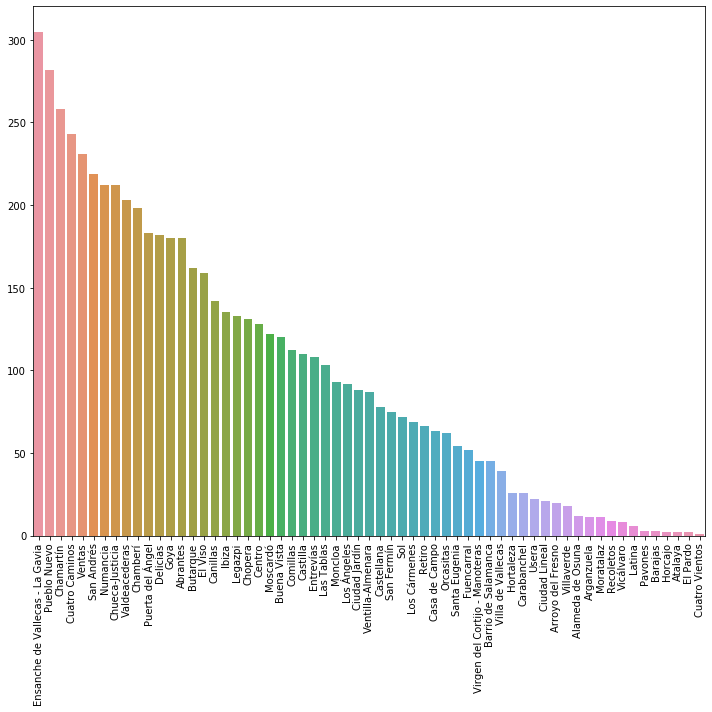

graph for is_floor_under: total = 3


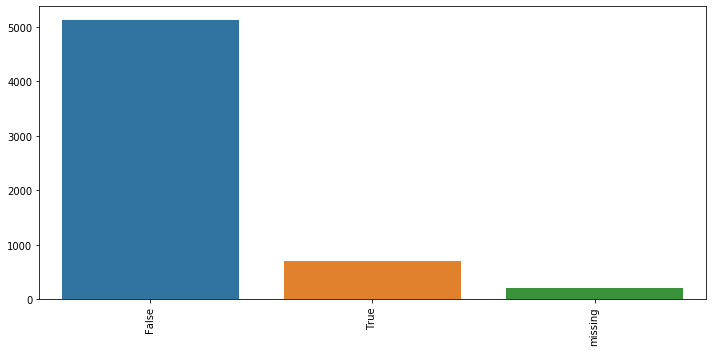

graph for floor: total = 12


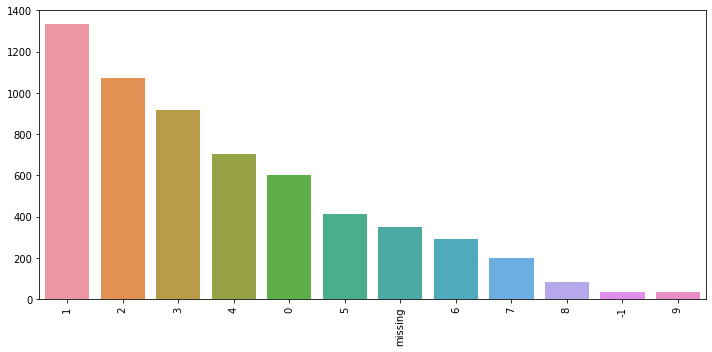

graph for house_type_id: total = 5


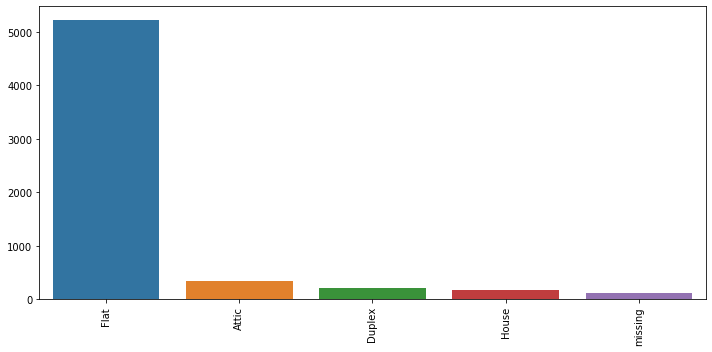

graph for has_lift: total = 3


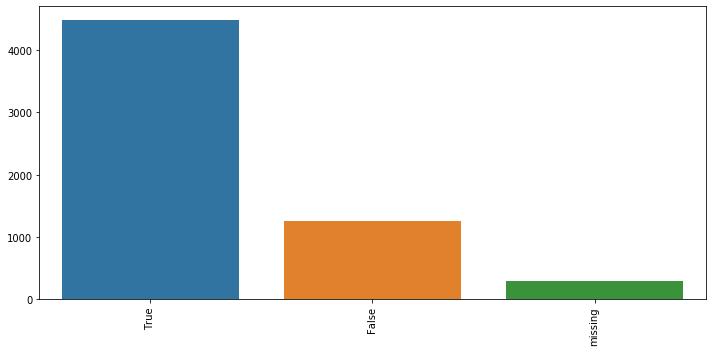

graph for energy_certificate: total = 10


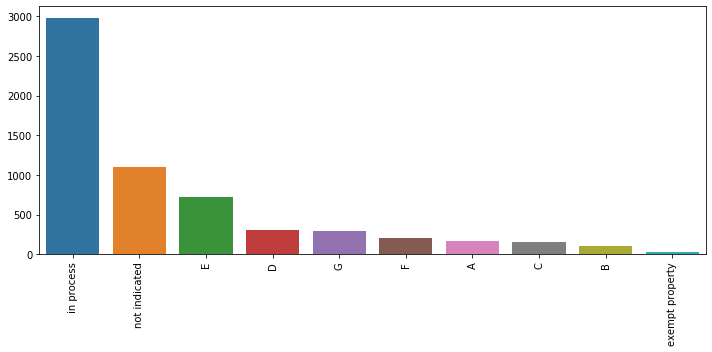

graph for is_exterior: total = 3


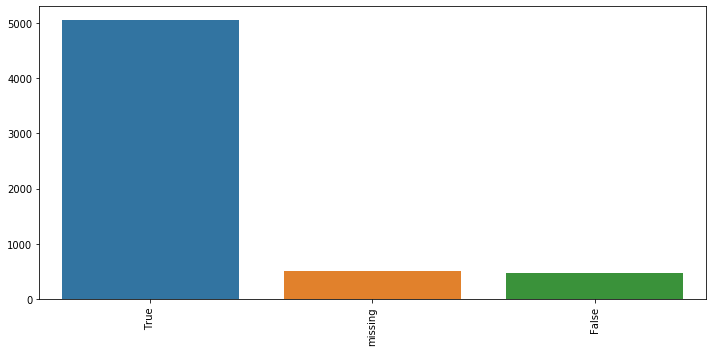

graph for is_new_development: total = 3


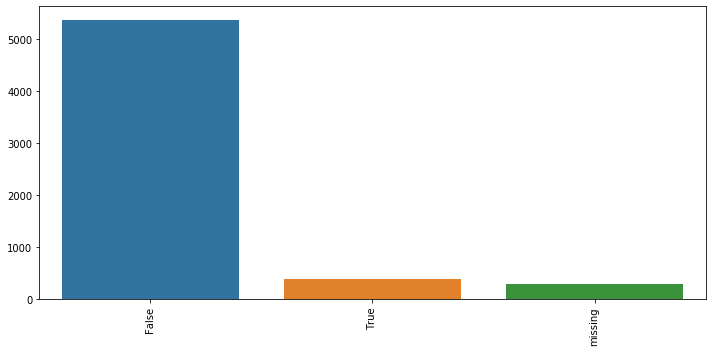

In [56]:
for i in df_cat_bar.columns:
    f=sns.barplot(x=df_cat_bar[i].value_counts().index, y=df_cat_bar[i].value_counts().values)
    print("graph for %s: total = %d" %(i, len(df_cat_bar[i].value_counts().index)))
    f.set_xticklabels(df_cat_bar[i].value_counts().index, rotation=90, fontsize=10)
    plt.rcParams["figure.figsize"] = (10,5)
    plt.tight_layout()
    plt.show()

In [57]:
# ;ets use some pivot tables to check differences among mean values
pivot1 = pd.pivot_table(df2, index=["house_type_id"], values= ["buy_price"], aggfunc="mean").sort_values(by="buy_price")

In [58]:
pivot1.reset_index(inplace=True)

In [59]:
# its usefull include the counts 
pivot1 = pd.pivot_table(df2, index=["house_type_id"], values= ["buy_price"], aggfunc=["mean","count","sem"]).stack().sort_values(by="mean").reset_index().drop("level_1",axis=1)

In [60]:
pivot1

,house_type_id,mean,count,sem
0,missing,2.454435e+05,111,29641.699708
1,Flat,5.278046e+05,5217,8513.410301
2,Attic,6.808824e+05,334,33013.520916
3,Duplex,6.825241e+05,201,50959.706108
4,House,1.258962e+06,173,85806.595641


Text(0.5, 0, 'Type House')

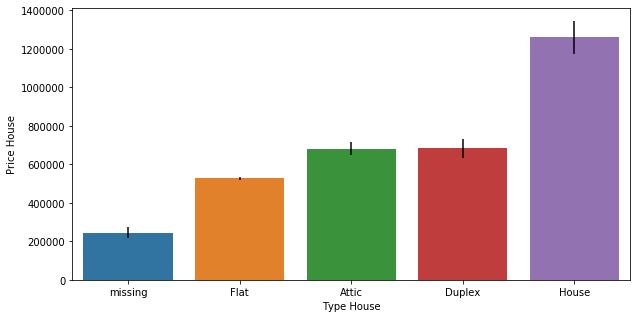

In [61]:
sns.barplot(x=pivot1["house_type_id"],y=pivot1["mean"], data=pivot1, yerr=pivot1["sem"])
plt.ylabel("Price House")
plt.xlabel("Type House")

In [62]:
pivot2 = pd.pivot_table(df2, index=["subtitle"], values= ["buy_price"], aggfunc=["mean","count","sem"]).stack().sort_values(by="mean").reset_index().drop("level_1",axis=1)

In [63]:
pivot2.rename({"level_0":"subtitle"}, axis=1, inplace=True)

In [64]:
pivot2

,subtitle,mean,count,sem
0,Entrevías,1.366010e+05,108,3927.313113
1,Los Ángeles,1.521598e+05,92,4136.844684
2,Numancia,1.584352e+05,212,4329.089520
3,San Andrés,1.634366e+05,219,4665.219965
4,Abrantes,1.686837e+05,180,5090.126510
5,Usera,1.722345e+05,22,14903.115091
6,Buena Vista,1.828510e+05,120,6493.769007
7,Moscardó,1.861082e+05,122,6544.312329
8,Latina,1.935000e+05,6,43010.657594
9,Orcasitas,2.025147e+05,62,7692.186646


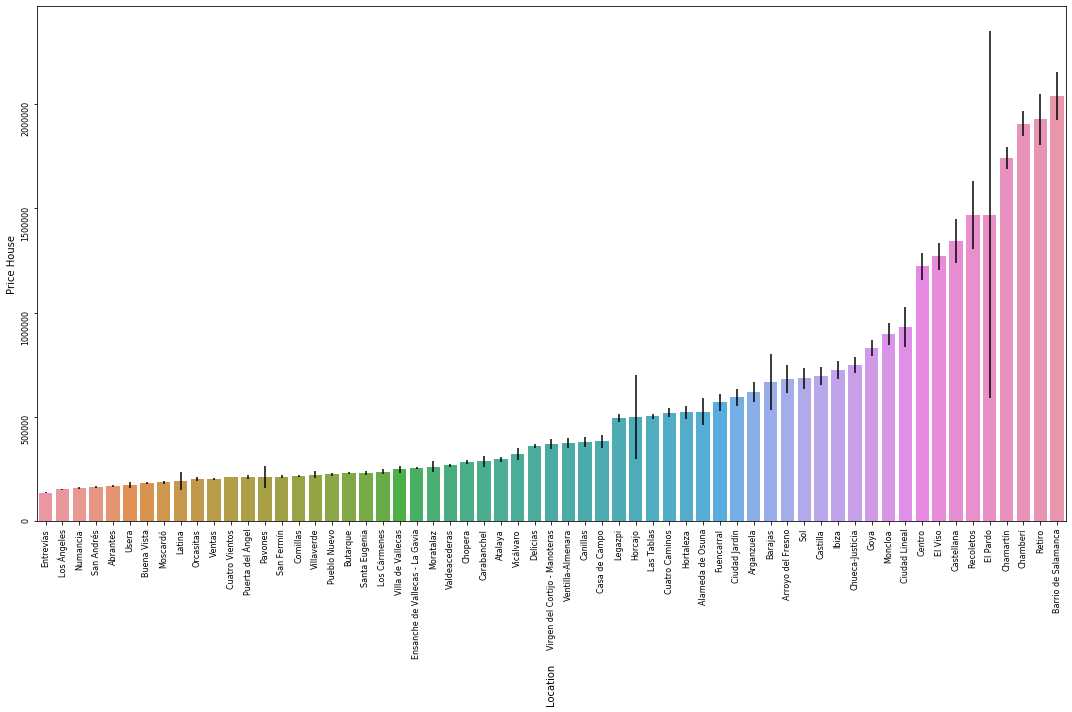

In [65]:
plt.rcParams["figure.figsize"] = (15,10)
sns.barplot(x=pivot2["subtitle"],y=pivot2["mean"], data=pivot2, yerr=pivot2["sem"])
plt.ylabel("Price House")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
# plt.savefig("location_price.png", dpi=400)
plt.show()


In [66]:
filt4 = df2["street_name"].str.contains("Habana", na=False)
habana="Calle de la Habana"
habana_m2 = float(df2.loc[filt4, "buy_price"].mean())
habana_count = float(df2.loc[filt4, "buy_price"].count())
habana_sem_m2 = float(df2.loc[filt4, "buy_price"].sem())
dictionary = {'subtitle': habana, 'mean': habana_m2, 'count': habana_count, 'sem': habana_sem_m2}
habana_row =pd.DataFrame(data=dictionary,index=[146])
pivot3_plushabana = pivot2.append(habana_row)

In [67]:
filt4 = df2["street_name"].str.contains("Burgos", na=False)
burgos="Avenida de Burgos"
burgos_m2 = float(df2.loc[filt4, "buy_price"].mean())
burgos_count = float(df2.loc[filt4, "buy_price"].count())
burgos_sem_m2 = float(df2.loc[filt4, "buy_price"].sem())
dictionary = {'subtitle': burgos, 'mean': burgos_m2, 'count': burgos_count, 'sem': burgos_sem_m2}
burgos_row =pd.DataFrame(data=dictionary,index=[146])
pivot3_plusburgos = pivot3_plushabana.append(burgos_row)

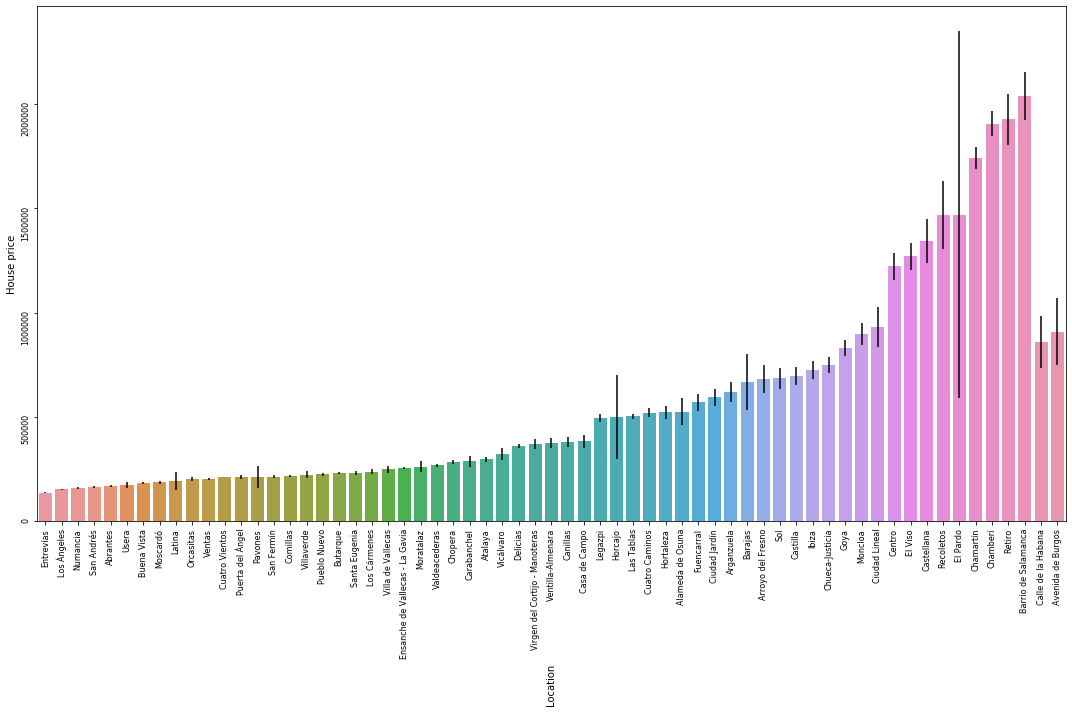

In [68]:
sns.barplot(x=pivot3_plusburgos["subtitle"],y=pivot3_plusburgos["mean"], data=pivot3_plusburgos, yerr=pivot3_plusburgos["sem"])
plt.ylabel("House price")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [69]:
pivot3 = pd.pivot_table(df2, index=["subtitle"], values= ["price_m2"], aggfunc=["mean","count","sem"]).stack().sort_values(by="mean").reset_index().drop("level_1",axis=1)

In [70]:
pivot3.rename({"level_0":"subtitle"}, axis=1, inplace=True)

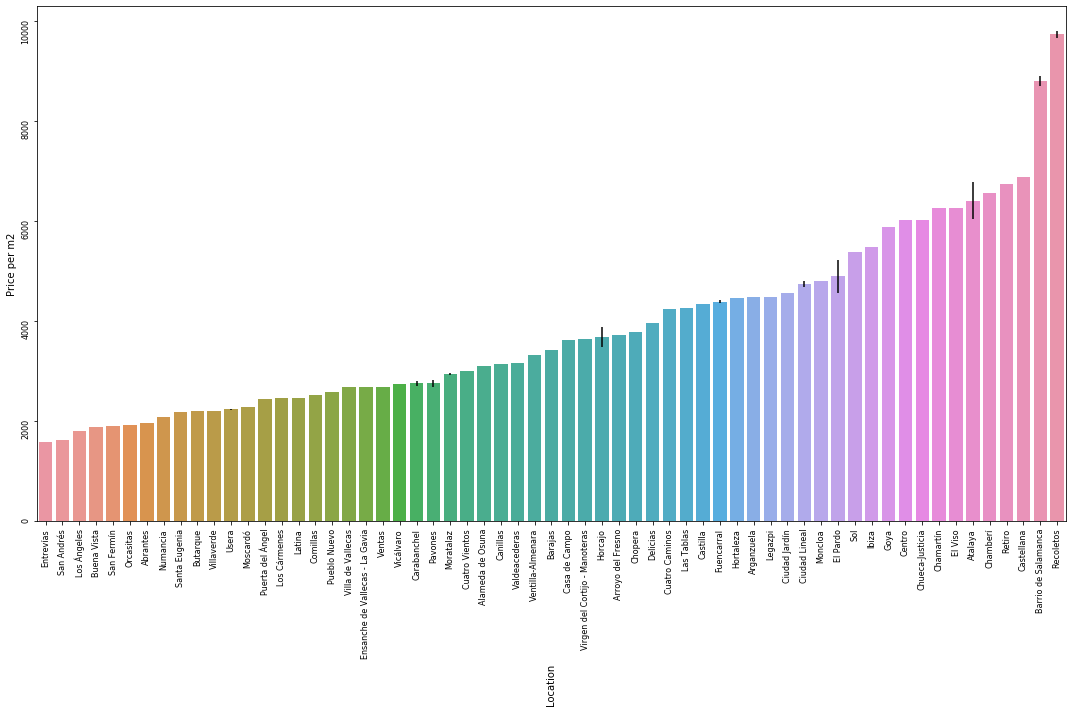

In [71]:
sns.barplot(x=pivot3["subtitle"],y=pivot3["mean"], data=pivot3, yerr=pivot3["sem"])
plt.ylabel("Price per m2")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
# plt.savefig("location_price_m2.png", dpi=400)
plt.show()

In [72]:
filt4 = df2["street_name"].str.contains("Habana", na=False)
habana="Calle de la Habana"
habana_m2 = float(df2.loc[filt4, "price_m2"].mean())
habana_count = float(df2.loc[filt4, "price_m2"].count())
habana_sem_m2 = float(df2.loc[filt4, "price_m2"].sem())
dictionary = {'subtitle': habana, 'mean': habana_m2, 'count': habana_count, 'sem': habana_sem_m2}
habana_row =pd.DataFrame(data=dictionary,index=[146])
pivot3_plushabana = pivot3.append(habana_row)

In [73]:
filt4 = df2["street_name"].str.contains("Burgos", na=False)
burgos="Avenida de Burgos"
burgos_m2 = float(df2.loc[filt4, "price_m2"].mean())
burgos_count = float(df2.loc[filt4, "price_m2"].count())
burgos_sem_m2 = float(df2.loc[filt4, "price_m2"].sem())
dictionary = {'subtitle': burgos, 'mean': burgos_m2, 'count': burgos_count, 'sem': burgos_sem_m2}
burgos_row =pd.DataFrame(data=dictionary,index=[146])
pivot3_plusburgos = pivot3_plushabana.append(burgos_row)

In [74]:
pivot3_plushabana

,subtitle,mean,count,sem
0,Entrevías,1574.360000,108.0,0.000000
1,San Andrés,1617.180000,219.0,0.000000
2,Los Ángeles,1796.680000,92.0,0.000000
3,Buena Vista,1886.600000,120.0,0.000000
4,San Fermín,1912.800000,75.0,0.000000
5,Orcasitas,1931.950000,62.0,0.000000
6,Abrantes,1964.550000,180.0,0.000000
7,Numancia,2081.940000,212.0,0.000000
8,Santa Eugenia,2175.930000,54.0,0.000000
9,Butarque,2197.800000,162.0,0.000000


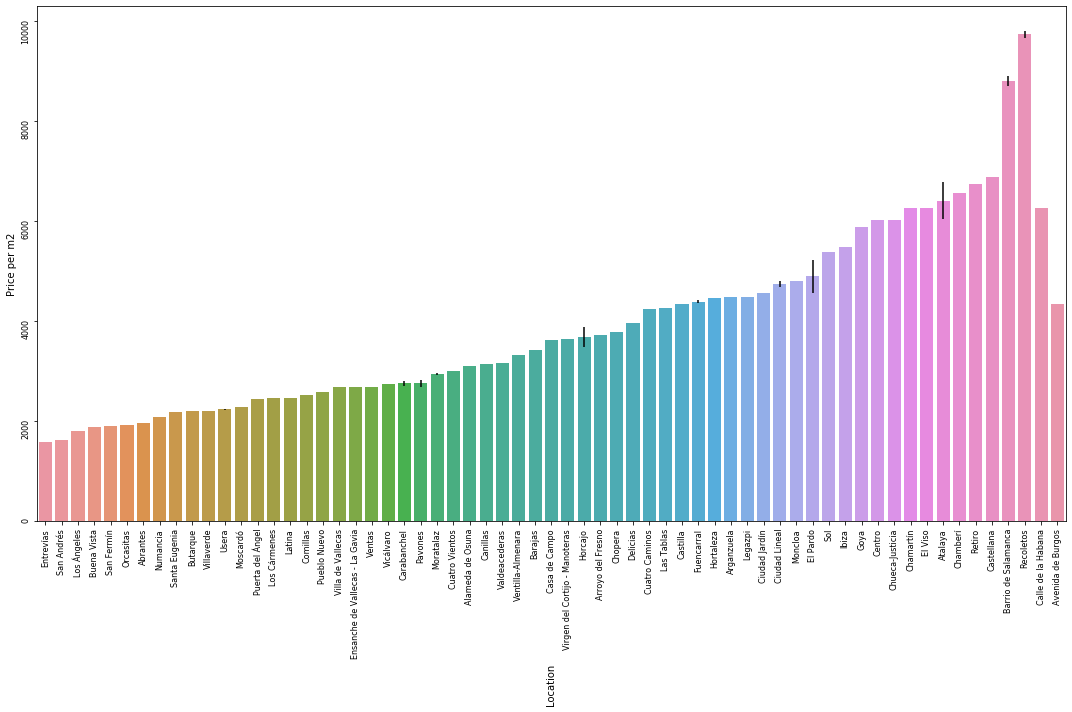

In [75]:
sns.barplot(x=pivot3_plusburgos["subtitle"],y=pivot3_plusburgos["mean"], data=pivot3_plusburgos, yerr=pivot3_plusburgos["sem"])
plt.ylabel("Price per m2")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("location_price_m2_removed_outliers.png", dpi=400)
plt.show()

In [76]:
pivot4 = pd.pivot_table(df2, index=["subtitle","house_type_id"], values=["buy_price"], aggfunc="count").reset_index().\
sort_values(by=["subtitle","buy_price"]).rename({"buy_price":"Number_Ads"}, axis=1)

In [77]:
filt3 = (pivot4["subtitle"] == "Barajas, Madrid") | (pivot4["subtitle"] == "Aravaca, Madrid")

In [78]:
pivot4.loc[filt3]

,subtitle,house_type_id,Number_Ads


In [79]:
filt2 = pivot4["house_type_id"] == "Flat"
maxim =pivot4.groupby("subtitle")["Number_Ads"].apply(max)
flats = pivot4.loc[filt2,"Number_Ads"]

In [80]:
maxim = pd.DataFrame(maxim).reset_index().drop("subtitle",axis=1).rename({"Number_Ads": "max_count"}, axis=1)

In [81]:
flats = flats.reset_index().drop("index", axis=1).rename({"Number_Ads": "flat_count"}, axis=1)

In [82]:
conc = pd.concat([maxim, flats], axis=1)

In [83]:
conc

,max_count,flat_count
0,175,175.0
1,8,8.0
2,6,6.0
3,14,14.0
4,2,2.0
5,2,2.0
6,43,43.0
7,111,111.0
8,136,136.0
9,108,108.0


In [84]:
for i in range(len(conc["max_count"])):
    if conc["max_count"][i] != conc["flat_count"][i]:
        print (i, conc["max_count"][i],conc["max_count"][i])

23 1 1
24 165 165
25 1 1
26 130 130
27 237 237
28 79 79
29 44 44
30 168 168
31 1 1
32 22 22
33 123 123
34 82 82
35 5 5
36 108 108
37 50 50
38 92 92
39 77 77
40 11 11
41 115 115
42 188 188
43 46 46
44 3 3
45 264 264
46 163 163
47 7 7
48 58 58
49 200 200
50 69 69
51 53 53
52 65 65
53 19 19
54 157 157
55 217 217
56 75 75
57 7 7
58 35 35
59 16 16
60 24 24


In [85]:
perc_flats = pivot4.groupby("subtitle")["Number_Ads"].apply(lambda x: (max(x)/sum(x))*100)

In [86]:
perc_flats = perc_flats.reset_index()

In [87]:
perc_flats.rename({"Number_Ads":"Flat_%"},axis=1, inplace=True)

In [88]:
pivot2.rename({"subtitle":"Area", "mean":"Price", "count":"Number_Ads", "sem":"SEM_price"}, axis=1, inplace=True)

In [89]:
pivot3.rename({"subtitle":"Area", "mean":"Price_Sqm", "count":"Number_Ads", "sem":"SEM_sqm"}, axis=1, inplace=True)

In [90]:
pivot3.drop(["Area","Number_Ads"], axis=1, inplace=True)

In [91]:
pivot_concat = pd.concat([pivot2, pivot3], axis=1)

In [92]:
pivot_concat.sort_values(by="Area", inplace=True)

In [93]:
pivot_concat = pivot_concat.reset_index().drop("index",axis=1)

In [94]:
pivot_concat

,Area,Price,Number_Ads,SEM_price,Price_Sqm,SEM_sqm
0,Abrantes,1.686837e+05,180,5090.126510,1912.800000,0.000000
1,Alameda de Osuna,5.249167e+05,12,63179.333303,4354.350000,0.000000
2,Arganzuela,6.198636e+05,11,46242.448568,4486.930000,0.000000
3,Arroyo del Fresno,6.830000e+05,20,66571.489077,4572.450000,0.000000
4,Atalaya,2.964500e+05,2,11450.000000,3152.530000,0.000000
5,Barajas,6.666667e+05,3,135841.001829,4486.930000,0.000000
6,Barrio de Salamanca,2.038511e+06,45,114400.694099,9741.222222,66.331612
7,Buena Vista,1.828510e+05,120,6493.769007,1964.550000,0.000000
8,Butarque,2.300418e+05,162,4852.572721,2677.280000,0.000000
9,Canillas,3.802460e+05,142,23834.099963,3636.960000,0.000000


In [95]:
perc_flats.sort_values(by="Flat_%")

,subtitle,Flat_%
25,El Pardo,50.000000
31,Horcajo,50.000000
20,Ciudad Lineal,52.380952
60,Virgen del Cortijo - Manoteras,53.333333
2,Arganzuela,54.545455
5,Barajas,66.666667
1,Alameda de Osuna,66.666667
10,Carabanchel,69.230769
3,Arroyo del Fresno,70.000000
37,Los Cármenes,72.463768


In [96]:
pivot_concat2 = pd.concat([pivot_concat, perc_flats], axis=1)

In [97]:
pivot_concat2 = pivot_concat2.drop("subtitle", axis=1)

In [98]:
pivot_concat2.corr()

,Price,Number_Ads,SEM_price,Price_Sqm,SEM_sqm,Flat_%
Price,1.000000,-0.012658,0.451416,0.957840,0.269704,-0.174174
Number_Ads,-0.012658,1.000000,-0.287237,-0.073888,-0.093907,0.249638
SEM_price,0.451416,-0.287237,1.000000,0.419621,0.080630,-0.452509
Price_Sqm,0.957840,-0.073888,0.419621,1.000000,0.275162,-0.219249
SEM_sqm,0.269704,-0.093907,0.080630,0.275162,1.000000,0.077282
Flat_%,-0.174174,0.249638,-0.452509,-0.219249,0.077282,1.000000


In [99]:
pivot_concat2.sort_values(by="Price").reset_index(drop=True, inplace=True)

In [100]:
pivot_concat2 = pivot_concat2.sort_values(by="Price")

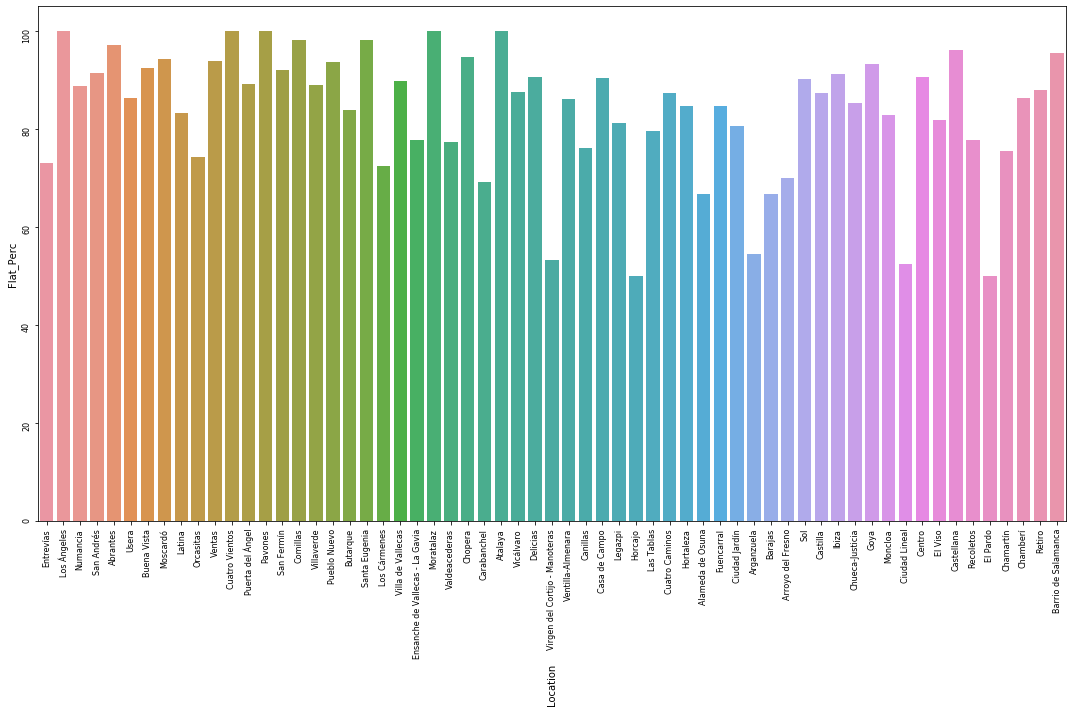

In [101]:
sns.barplot(x=pivot_concat2["Area"],y=pivot_concat2["Flat_%"])
plt.ylabel("Flat_Perc")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [102]:
df2.shape

(6036, 22)

In [103]:
gbArea = df2.groupby("subtitle")

In [104]:
list_dfs = [gbArea.get_group(x) for x in gbArea.groups]

In [105]:
list_areas = df2["subtitle"].unique()

In [106]:
pivot5 = pd.pivot_table(df2, index=["subtitle"], values=["sq_mt_built"], aggfunc="mean").reset_index().sort_values(by="sq_mt_built")

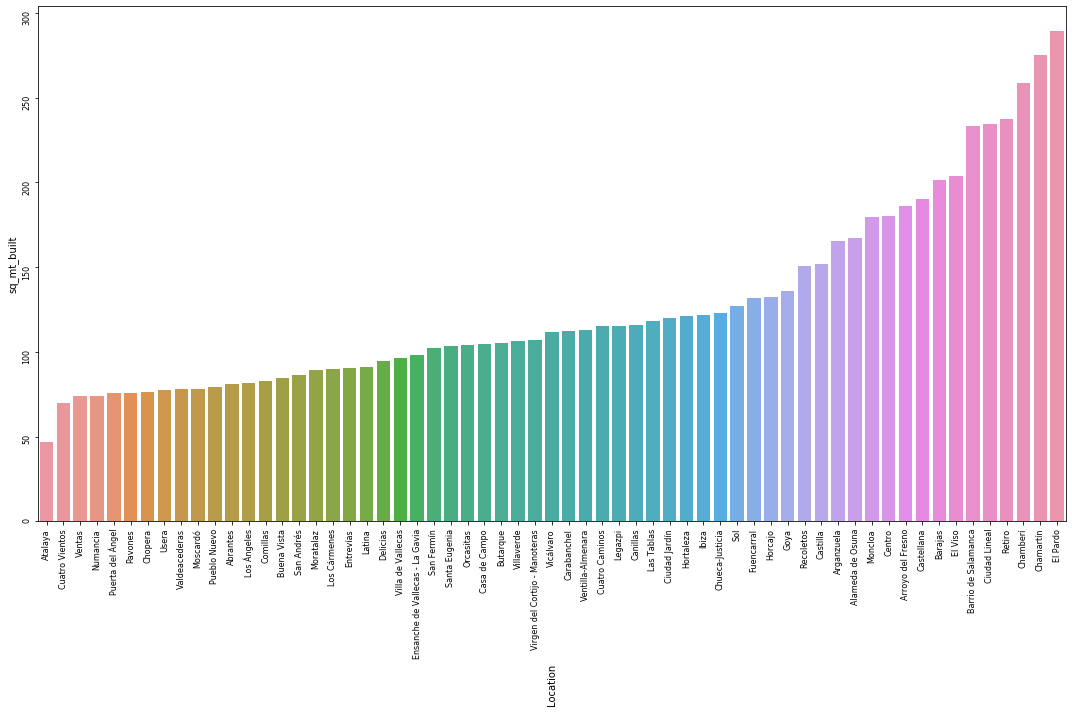

In [107]:
sns.barplot(x=pivot5["subtitle"],y=pivot5["sq_mt_built"])
plt.ylabel("sq_mt_built")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [129]:
avg_m2_habana = df2.loc[(df2["street_name"].str.contains("Burgos"))]["sq_mt_built"].mean() #175
avg_m2_burgos = df2.loc[(df2["street_name"].str.contains("Habana"))]["sq_mt_built"].mean() #148
burgos="Avenida de Burgos"
habana = "Paseo de la Habana"
dictionary = {'subtitle': [burgos,habana], 'sq_mt_built': [avg_m2_burgos, avg_m2_habana]}
burgos_row =pd.DataFrame(data=dictionary,index=[147,148])
pivot5 = pivot5.append(burgos_row)

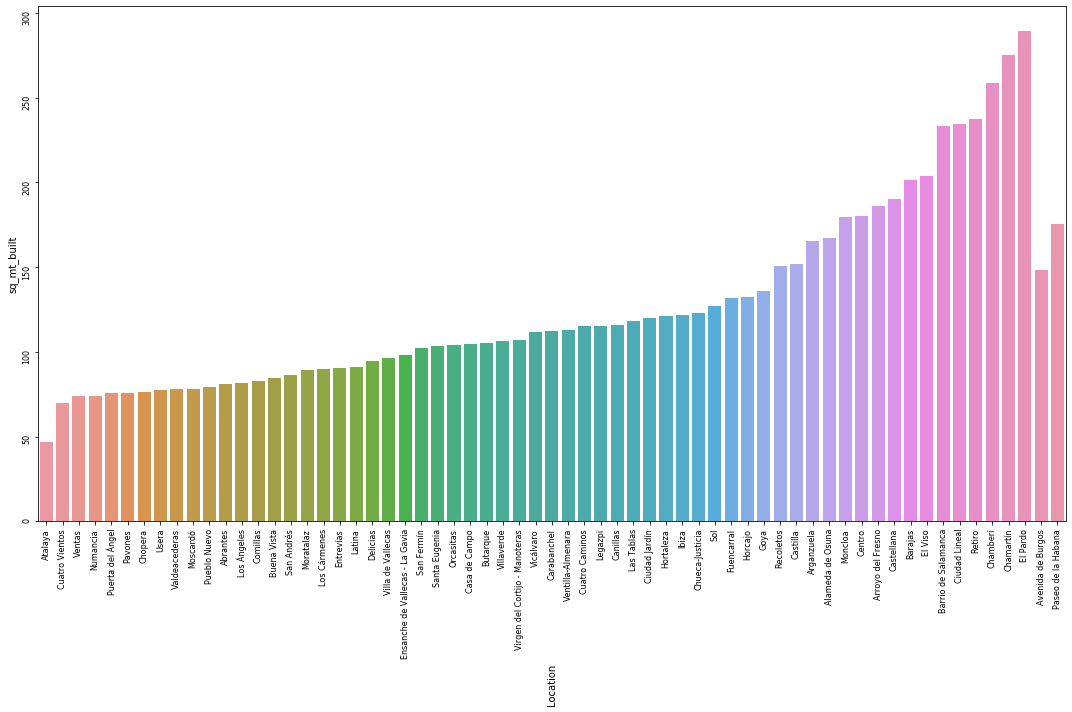

In [292]:
sns.barplot(x=pivot5["subtitle"],y=pivot5["sq_mt_built"])
plt.ylabel("sq_mt_built")
plt.xlabel("Location",rotation=90)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("location_sq_m2_removed_outliers.png", dpi=400)
plt.show()

In [109]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [110]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print("r2", round(r_value**2,2))

Abrantes
r2 0.32


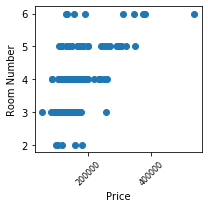

Alameda de Osuna
r2 0.7


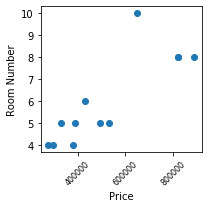

Arganzuela
r2 0.29


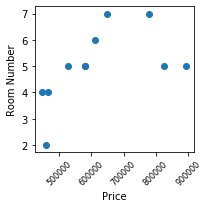

Arroyo del Fresno
r2 0.76


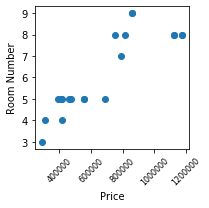

Atalaya
r2 0.0


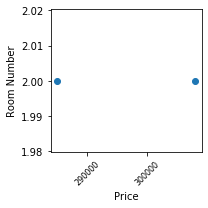

Barajas
r2 1.0


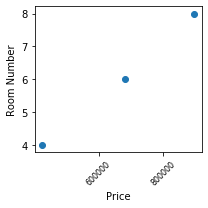

Barrio de Salamanca
r2 0.56


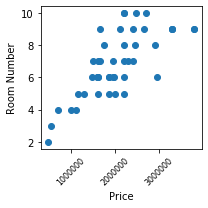

Buena Vista
r2 0.24


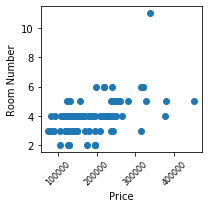

Butarque
r2 0.46


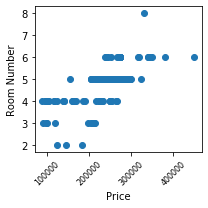

Canillas
r2 0.64


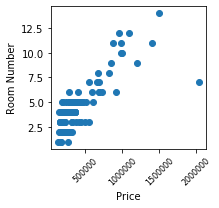

Carabanchel
r2 0.33


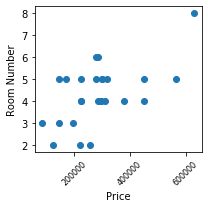

Casa de Campo
r2 0.53


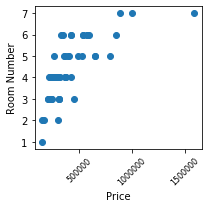

Castellana
r2 0.7


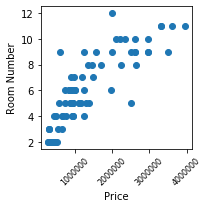

Castilla
r2 0.53


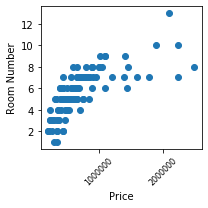

Centro
r2 0.28


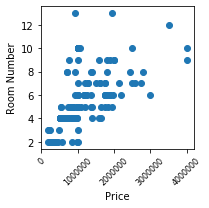

Chamartín
r2 0.47


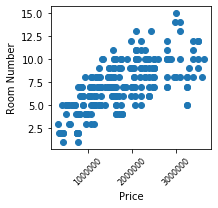

Chamberí
r2 0.56


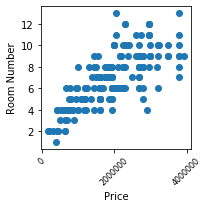

Chopera
r2 0.38


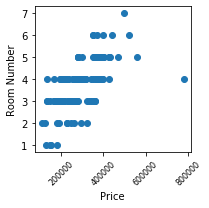

Chueca-Justicia
r2 0.47


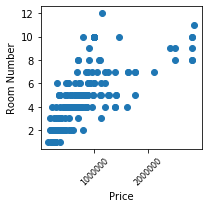

Ciudad Jardín
r2 0.57


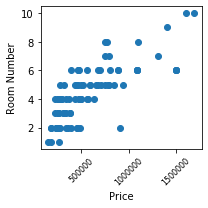

Ciudad Lineal
r2 0.78


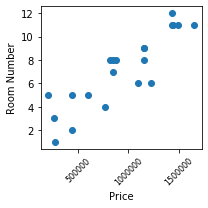

Comillas
r2 0.25


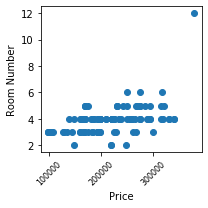

Cuatro Caminos
r2 0.46


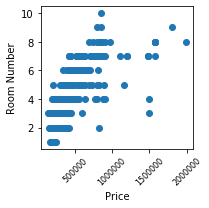

Cuatro Vientos
r2 0.0


C:\Users\enriq\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\enriq\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\enriq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\enriq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\enriq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\enriq\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalar

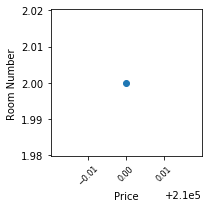

Delicias
r2 0.44


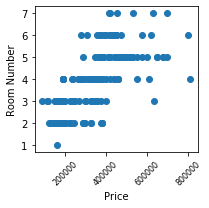

El Pardo
r2 1.0


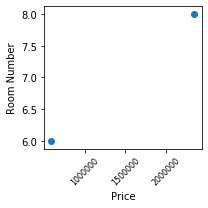

El Viso
r2 0.69


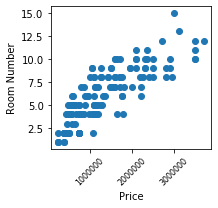

Ensanche de Vallecas - La Gavia
r2 0.65


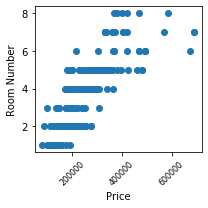

Entrevías
r2 0.2


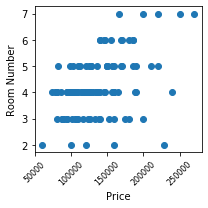

Fuencarral
r2 0.4


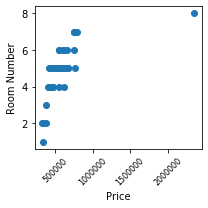

Goya
r2 0.46


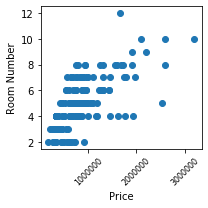

Horcajo
r2 1.0


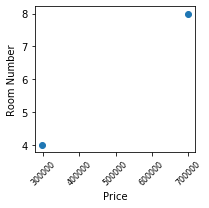

Hortaleza
r2 0.7


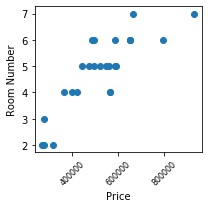

Ibiza
r2 0.48


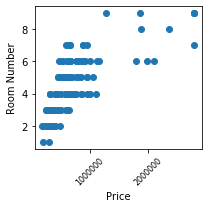

Las Tablas
r2 0.64


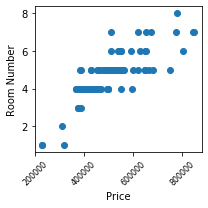

Latina
r2 0.68


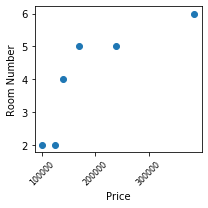

Legazpi
r2 0.28


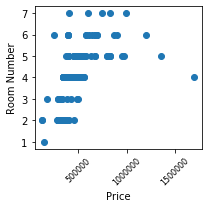

Los Cármenes
r2 0.33


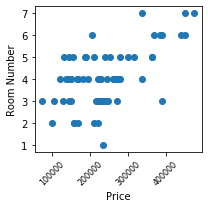

Los Ángeles
r2 0.27


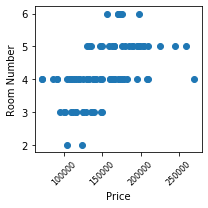

Moncloa
r2 0.52


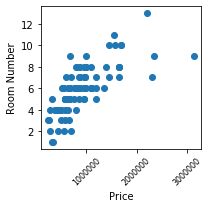

Moratalaz
r2 0.62


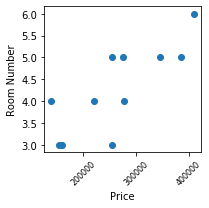

Moscardó
r2 0.39


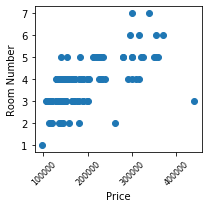

Numancia
r2 0.23


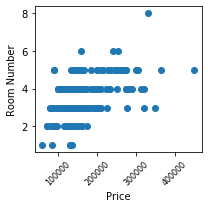

Orcasitas
r2 0.1


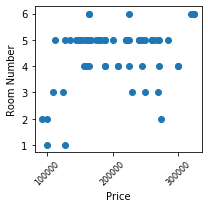

Pavones
r2 0.88


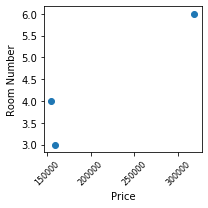

Pueblo Nuevo
r2 0.37


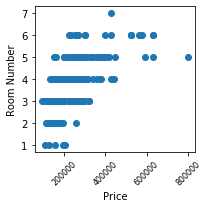

Puerta del Ángel
r2 0.41


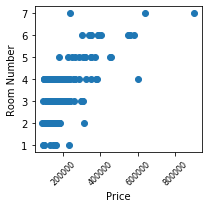

Recoletos
r2 0.77


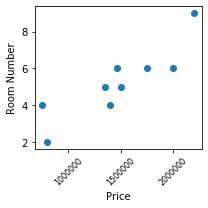

Retiro
r2 0.38


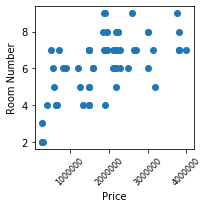

San Andrés
r2 0.4


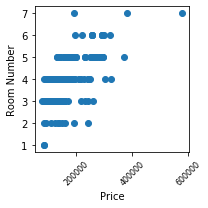

San Fermín
r2 0.27


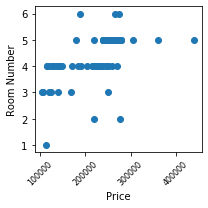

Santa Eugenia
r2 0.59


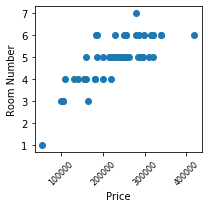

Sol
r2 0.56


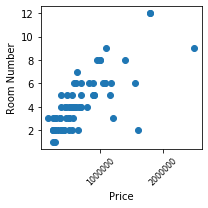

Usera
r2 0.42


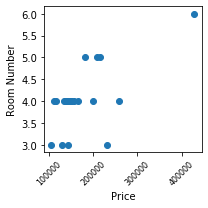

Valdeacederas
r2 0.33


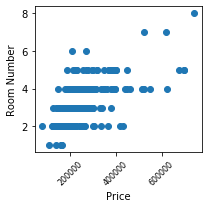

Ventas
r2 0.2


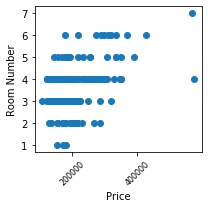

Ventilla-Almenara
r2 0.75


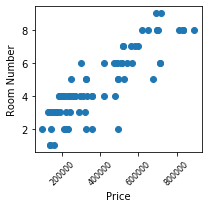

Vicálvaro
r2 0.52


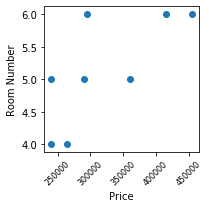

Villa de Vallecas
r2 0.73


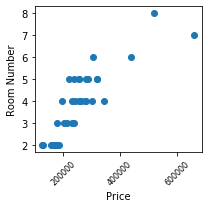

Villaverde
r2 0.53


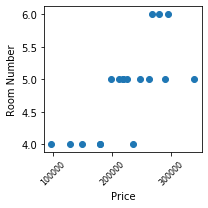

Virgen del Cortijo - Manoteras
r2 0.62


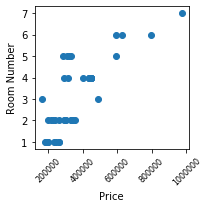

In [111]:
for i in range(len(list_dfs)):
        fig, ax = plt.subplots(1, figsize=(3, 3))
        x=np.array(list_dfs[i]["buy_price"])
        y=np.array(list_dfs[i]["total_rooms"])
        plt.scatter(x,y)
        print(list_areas[i])
        rsquared(x,y)
        plt.xticks(rotation=45, fontsize=8)
        plt.xlabel("Price")
        plt.ylabel("Room Number")
        plt.tight_layout()
        plt.show()

# 4. Model Building 

In [239]:
df2.rename({"subtitle":"location"}, axis=1, inplace=True)

In [240]:
df2.columns

Index(['location', 'sq_mt_built', 'n_rooms', 'n_bathrooms',
       'is_exact_address_hidden', 'street_name', 'floor', 'is_floor_under',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'has_lift', 'is_exterior', 'energy_certificate',
       'has_parking', 'price_m2', 'total_rooms', 'm2_per_room', 'Habana',
       'Burgos'],
      dtype='object')

In [241]:
# I will add tow columns of personal interes
df2["Habana"] = df2["street_name"].apply(lambda x: 1 if "habana" in x.lower() else 0)
df2["Burgos"] = df2["street_name"].apply(lambda x: 1 if "burgos" in x.lower() else 0)

In [242]:
df_model = (df2[["location","sq_mt_built","n_rooms","n_bathrooms","buy_price"]])

In [243]:
df_dummy = pd.get_dummies(df_model)

In [244]:
list_loc_col = df_dummy.columns[df_dummy.columns.str.contains("location")]

In [245]:
list_loc_new=[]
for i in list_loc_col:
    loc = i.replace("location_", "")
    list_loc_new.append(loc)

In [246]:
dict_locs = dict(zip(list_loc_col,list_loc_new))

In [247]:
df_dummy.rename(dict_locs, axis=1, inplace=True)

In [248]:
from sklearn.model_selection import train_test_split
X = df_dummy.drop("buy_price", axis=1)
y = df_dummy["buy_price"].values # This returns an array which is the data structure advised to be used in model building
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # 0.2 means 80 % is in

#### Linear Regression

In [249]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test,y_test) # Gives us an idea of how good the model is (0.845 pretty_good)

0.8934265081754884

###### K-fold cross-validation

In [250]:
from sklearn.model_selection import ShuffleSplit # It will randomized the samples so that each fold will have equal distrubution
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(lr, X, y, cv=cv).mean() # The mean value of our 5*cv gives us a good idea of how pur model is performing

0.8816133885533656

In [251]:
cv_MAE = (cross_val_score(lr, X_train, y_train, scoring = "neg_mean_absolute_error", cv=3)).mean()

In [252]:
cv_MAE

-129404.76942659066

#### Exploring other models

In [254]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# we can use a function to fing best model using GridSearchCV

def find_model(X,y):
    algos = {
        "linear_regression" : {"model":LinearRegression(), "params":{"normalize": [True,False]}},
#         "random_forest" : {"model":RandomForestRegressor(), "params":{"criterion": ["mse","mae"]}},
        "decission_tree" : {"model":DecisionTreeRegressor(), "params":{"criterion": ["mse","friedman_mse"], "splitter":["best", "random"]}}
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for model, config in algos.items(): 
        gs = GridSearchCV(config["model"], config["params"], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({"model": model,
                      "best_score" : gs.best_score_,
                      "best_params": gs.best_params_})
                      
    return pd.DataFrame(scores, columns=["model","best_score","best_params"])

find_model(X,y)

,model,best_score,best_params
0,linear_regression,0.881613,{'normalize': False}
1,decission_tree,0.857017,"{'criterion': 'mse', 'splitter': 'random'}"


* [ClickHere To check documentation for the Linear Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

* [ClickHere To check documentation for the Lasso Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

* [ClickHere To check documentation for the DecisionTreeRegressor Model](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [255]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)
# l = linear_model.Lasso(alpha=1, selection="cyclic")
# l.fit(X_train, y_train)
rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfr.fit(X_train, y_train)
dtr = DecisionTreeRegressor(criterion="friedman_mse", splitter="best")
dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [256]:
cv_rfr = (cross_val_score(rfr, X_train, y_train, cv=3)).mean() #0.89

In [257]:
cv_rfr

0.8921998735003399

In [258]:
X.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'Abrantes', 'Alameda de Osuna',
       'Arganzuela', 'Arroyo del Fresno', 'Atalaya', 'Barajas',
       'Barrio de Salamanca', 'Buena Vista', 'Butarque', 'Canillas',
       'Carabanchel', 'Casa de Campo', 'Castellana', 'Castilla', 'Centro',
       'Chamartín', 'Chamberí', 'Chopera', 'Chueca-Justicia', 'Ciudad Jardín',
       'Ciudad Lineal', 'Comillas', 'Cuatro Caminos', 'Cuatro Vientos',
       'Delicias', 'El Pardo', 'El Viso', 'Ensanche de Vallecas - La Gavia',
       'Entrevías', 'Fuencarral', 'Goya', 'Horcajo', 'Hortaleza', 'Ibiza',
       'Las Tablas', 'Latina', 'Legazpi', 'Los Cármenes', 'Los Ángeles',
       'Moncloa', 'Moratalaz', 'Moscardó', 'Numancia', 'Orcasitas', 'Pavones',
       'Pueblo Nuevo', 'Puerta del Ángel', 'Recoletos', 'Retiro', 'San Andrés',
       'San Fermín', 'Santa Eugenia', 'Sol', 'Usera', 'Valdeacederas',
       'Ventas', 'Ventilla-Almenara', 'Vicálvaro', 'Villa de Vallecas',
       'Villaverde', 'Virgen del C

In [259]:
# Lets write a predict function

def predict_price(location, sq_mt_built, n_bathrooms, n_rooms):
    loc_index = np.where(X.columns==location)[0][0] # X is an np array so we use where method to loc the index
    
    x= np.zeros(len(X.columns))
    x[0] = sq_mt_built
    x[1] = n_rooms
    x[2] = n_bathrooms
    if loc_index >= 0:
        x[loc_index] = 1
    print(x)
        
    return rfr.predict([x])[0]   
    

In [277]:
predict_price('Chamartín',119,2,3)

[119.   3.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]


701673.8353333332

In [261]:
dtr_pred = dtr.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [262]:
from sklearn import metrics
metrics.mean_absolute_error(y_test, dtr_pred)

100935.8737510512

In [279]:
metrics.mean_absolute_error(y_test, rfr_pred)

90992.92999750916

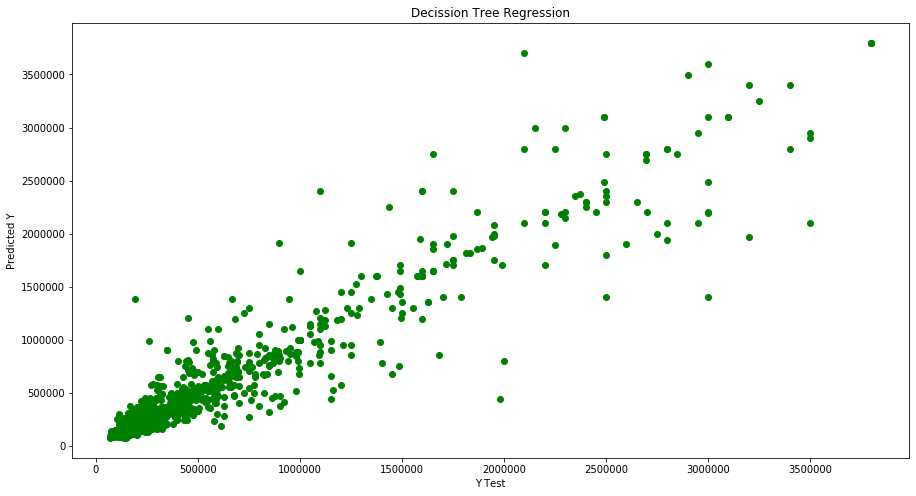

In [285]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.title("Decission Tree Regression")
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.savefig("Decision Tree Data.png", dpi=400)
plt.show()

In [264]:

rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

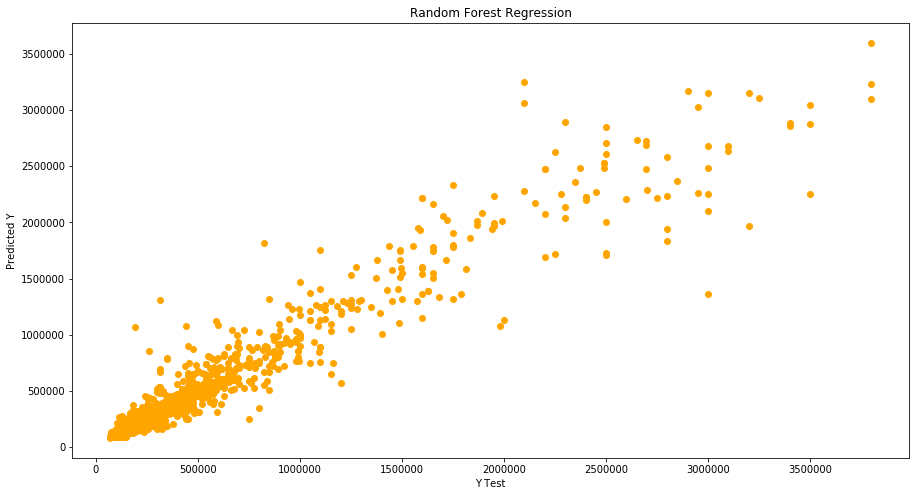

In [286]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.title("Random Forest Regression")
plt.ylabel('Predicted Y')
plt.savefig("Random Forest Data.png", dpi=400)
plt.show()

# 5. Productionazing the model

In [288]:
# Exporting the model
import pickle
with open ("Madrid_home_price_mode_Nooutliers.pickle", "wb") as f:
    pickle.dump(rfr,f)

In [291]:
# Also it is important to export the column info that give us the index to apply our model
import json
columns = {"data_columns":[col.lower() for col in X.columns]}
with open("columns_Nooutliers.json", "w") as f:
    f.write(json.dumps(columns))

The next step is to write a Python flash server which can send Http requests.

* Create a server.py in server folder

* Create util.py in server folder

* Save our artifacts in server folder also

